# 手机定价分类

## 概述

本文处理的学习任务是根据一台手机的各类属性(如电池容量, 是否支持蓝牙等等)推断该手机的定价类别(低定价或高定价).
本文采用的数据集为[dataset](https://www.kaggle.com/iabhishekofficial/mobile-price-classification?select=train.csv).
原始数据集将定价分为四类: "低", "中", "高"与"非常高", 本文将"低"与"中"合并为低定价, 将"高"与"非常高"合并为高定价.
本文处理的是一个二分类任务, 正类为高定价, 用$1$表示, 反类为低定价, 用$0$表示.

数据集以8:1:1的比例被切分为训练集, 验证集和测试集. 本文以逻辑回归, 朴素贝叶斯分类器和支持向量机三种学习算法处理学习任务,
并对比了这三种方法在测试集上的预测准确率, 在训练集上的预测准确率和训练用时. 本文还分析了这三种学习算法的差异与优缺点.

## 导入所需的包与类

In [1]:
import math
import pandas
import functools
import time
import seaborn
from matplotlib import pyplot
from sklearn.svm import SVC

## 工具函数
### 数据集切分
函数`split(data, train, valid, test)`按照`train`:`valid`:`test`的比例将表格`data`横向切分为三份,
并返回这三份表格.

In [2]:
def split(data, train, valid, test):
    # calculate the size of each part
    size = len(data)
    size_train = int(size * train / (train + valid + test))
    size_valid = int(size * valid / (train + valid + test))

    # split the data
    data_train = data[0:size_train].copy()
    data_valid = data[size_train:size_train + size_valid].copy()
    data_test = data[size_train + size_valid:size].copy()

    return data_train, data_valid, data_test

### 分离属性与标记
函数`get_xs_ys(data)`将表格`data`中标记一列(price_range)与其他列分离开来,
并返回分离后的两部分.

In [3]:
def get_xs_ys(data):
    xs = data.drop('price_range', axis=1).values.tolist()
    ys = data['price_range'].values.tolist()
    return xs, ys

### 计算预测准确率
函数`score(model, xs, ys)`用模型`model`对一组样本`xs`进行预测,
并将预测结果与相应的一组参考标记`ys`进行比对, 计算出预测准确率.

In [4]:
def score(model, xs, ys):
    # conduct the prediction
    predicted_ys = model.predict(xs)

    # calculate the error rate
    return sum([y == predicted_y for y, predicted_y in zip(ys, predicted_ys)]) / len(xs)

### 驱动函数
函数`run(preprocessor, model_class, data)`依次执行预处理, 数据集切分, 模型训练与预测准确率评估,
然后返回测试集上的预测准确率, 训练集上的预测准确率与模型训练所用时间(单位: 秒).
所用预处理函数由参数`preprocessor`指定, 所用学习算法由参数`model_class`指定,
所用数据由参数`data`指定.

In [5]:
def run(preprocessor, model_class, data):
    # preprocess
    data = preprocessor(data)

    # split the data into training set, validation set and test set
    data_train, data_valid, data_test = split(data, 8, 1, 1)

    # split attributes and label
    xs_train, ys_train = get_xs_ys(data_train)
    xs_valid, ys_valid = get_xs_ys(data_valid)
    xs_test, ys_test = get_xs_ys(data_test)

    # train a model
    model = model_class()
    time_start = time.time()
    model.fit(xs_train, ys_train)
    time_finish = time.time()

    # calculate the error rates and the time used to train the model
    score_test = score(model, xs_test, ys_test)
    score_train = score(model, xs_train, ys_train)
    time_cost = time_finish - time_start

    return score_test, score_train, time_cost

## 预处理函数与模型类

对于每个学习算法, 都有一个预处理函数与一个模型类.

预处理函数`preprocess(data)`对表格`data`中的原始数据进行预处理,
然后返回处理后的数据表格.

模型类有两个成员方法. 第一个成员方法是`fit(self, xs, ys)`,
它会使用一组样本`xs`与对应的一组标记`ys`来训练模型, 并将训练得到的模型存放在`self`对象中.
第二个成员方法是`predict(self, xs)`, 它会使用`self`对象中的模型来对一组样本`xs`进行预测,
然后返回预测结果(一组标记).

### 逻辑回归

逻辑回归的预处理函数为`preprocess_logistic`. 在预处理过程中,
原始数据中每个属性值都调整到$[0, 1]$区间中, 这样做可以避免模型训练过程中出现数据溢出的问题.

In [6]:
def preprocess_logistic(data):
    # avoid to change the original DataFrame object
    data = data.copy()

    # normalize data
    for col_name in data.columns:
        if col_name != 'price_range':
            s = data[col_name].max()
            data[col_name] = data[col_name].apply(lambda x: x / s)

    return data

逻辑回归的模型类为`LogisticRegression`. 成员变量`ws`表示模型对应的$logit$函数的参数向量$(w_0, w_1, \ldots, w_d)$.
私有成员方法`_calc_post_prob(self, x)`使用`self`对象中的模型计算样本`x`属于正类的后验概率.

In [7]:
class LogisticRegression:
    def __init__(self):
        self.ws = []

    def fit(self, xs, ys):
        # define constants
        eta = 0.005
        conv_bound = 0.01 # convergence bound

        # calculate number of attributes
        attr_num = len(xs[0]) + 1

        # initialize params of logit function
        self.ws = [0.0] * attr_num

        # learn the params with gradient-descent algorithm
        while True:
            dws = [0.0] * attr_num
            for x, y in zip(xs, ys):
                post_prob = self._calc_post_prob(x)
                dws = [dw + (y - post_prob) * attr for dw, attr in zip(dws, [1.0, *x])]
            if all([abs(eta * dw) < conv_bound for dw in dws]):
                break
            self.ws = [w + eta * dw for w, dw in zip(self.ws, dws)]

    def predict(self, xs):
        return [int(self._calc_post_prob(x) > 0.5) for x in xs]

    def _calc_post_prob(self, x):
        a = sum([w * attr for w, attr in zip(self.ws, [1.0, *x])])
        return 1 / (1 + math.exp(-a))

### 朴素贝叶斯分类器

朴素贝叶斯分类器的预处理函数为`preprocess_bayesian`. 原始数据中,
有一些属性有很多可能的取值, 使得模型在预测时难以用训练数据估计这些属性上的似然.
在预处理过程中, 对于这些属性, 属性取值范围被划分为一组区间, 每个属性值被其所属的区间的编号所替代.

In [8]:
def preprocess_bayesian(data):
    # avoid to change the original DataFrame object
    data = data.copy()

    # discretize continuous attributes into intervals
    # split large numbers into ranges
    data['battery_power'] = pandas.cut(data['battery_power'], 10, labels=False)
    data['clock_speed'] = pandas.cut(data['clock_speed'], 10, labels=False)
    data['int_memory'] = pandas.cut(data['int_memory'], 10, labels=False)
    data['mobile_wt'] = pandas.cut(data['mobile_wt'], 10, labels=False)
    data['px_height'] = pandas.cut(data['px_height'], 10, labels=False)
    data['px_width'] = pandas.cut(data['px_width'], 10, labels=False)
    data['ram'] = pandas.cut(data['ram'], 10, labels=False)

    return data

朴素贝叶斯分类器的模型类为`NaiveBayesianClassifier`.
成员变量`tables`的意义: `tables[c][i][x]`记录了训练数据中属于第`c`类且第`i`个属性取值为`x`的样例个数.
成员变量`ns`记录了训练数据中正类与反类的样例个数. 模型的训练过程即为统计得到这两个成员变量的过程.

In [9]:
class NaiveBayesianClassifier:
    def __init__(self):
        self.tables = [[], []]
        self.ns = [0, 0]

    def fit(self, xs, ys):
        # calculate number of attributes
        attr_num = len(xs[0])

        # count
        for c in [0, 1]:
            self.ns[c] = ys.count(c)
            self.tables[c] = [dict() for _ in range(attr_num)]
            for x, y in zip(xs, ys):
                if y == c:
                    for attr, row in zip(x, self.tables[c]):
                        row.setdefault(attr, 0)
                        row[attr] += 1

    def predict(self, xs):
        # calculate number of attributes
        attr_num = len(xs[0])

        # calculate the prior probabilities
        total = sum(self.ns)
        prior_probs = [self.ns[c] / total for c in [0, 1]]

        # conduct the prediction
        ys = []
        for x in xs:
            f = [0.0, 0.0]
            for c in [0, 1]:
                # calculate the likelihood of each attribute
                likelihoods = [self.tables[c][i].get(x[i], 0) / self.ns[c] for i in range(attr_num)]
                # calculate the decision function value
                f[c] = functools.reduce(lambda v, e: v * e, [prior_probs[c], *likelihoods])
            # take the class with the max decision function value
            ys.append(f.index(max(f)))

        return ys

### 支持向量机

支持向量机的预处理函数为`preprocess_svm`. 预处理过程没有对原始数据做修改.

In [10]:
def preprocess_svm(data):
    # avoid to change the original DataFrame object
    data = data.copy()

    return data

支持向量机的模型类为`SVM`. 该类的实现借助了`sklearn.svm.SVC`类.

In [11]:
class SVM:
    def __init__(self):
        self.svc = SVC()

    def fit(self, xs, ys):
        self.svc.fit(xs, ys)

    def predict(self, xs):
        return self.svc.predict(xs)

## 学习算法对比

函数`compare(n)`将原始数据打乱`n`次, 产生`n`种不同的数据集切分,
对于每一种数据集切分, 测试三种学习算法在测试集上的预测准确率, 在训练集上的预测准确率与训练用时.
该函数会以表格形式输出平均预测准确率与平均训练用时, 还会以柱状图的形式对比不同学习算法的平均预测准确率.

In [12]:
def compare(n):
    # define the name of each method
    names = ['logistic', 'bayesian', 'svm']

    # define the preprocessor and the model class of each method
    preprocessors = {
        'logistic': preprocess_logistic,
        'bayesian': preprocess_bayesian,
        'svm': preprocess_svm
    }
    model_classes = {
        'logistic': LogisticRegression,
        'bayesian': NaiveBayesianClassifier,
        'svm': SVM
    }

    # initialize the statistics
    avg_scores_test = {'logistic': 0.0, 'bayesian': 0.0, 'svm': 0.0}
    avg_scores_train = {'logistic': 0.0, 'bayesian': 0.0, 'svm': 0.0}
    avg_elapsed_times = {'logistic': 0.0, 'bayesian': 0.0, 'svm': 0.0}

    # read the data
    data = pandas.read_csv('train.csv')

    # convert labels into two classes
    data['price_range'].replace([1, 2, 3, 4], [0, 0, 1, 1], True)

    # repeat the experiment n times
    for _ in range(n):
        # shuffle the data
        data = data.sample(frac=1)
        # run the experiment for each method
        for name in names:
            score_test, score_train, elapsed_time = run(preprocessors[name], model_classes[name], data)
            avg_scores_test[name] += score_test / n
            avg_scores_train[name] += score_train / n
            avg_elapsed_times[name] += elapsed_time / n

    # print the statistics
    print('Method    Accuracy (Test)  Accuracy (Training)  Time (sec)')
    fmt_str = '{:<8}  {:>15.2%}  {:>19.2%}  {:>10.3f}'
    for name in names:
        print(fmt_str.format(name, avg_scores_test[name], avg_scores_train[name], avg_elapsed_times[name]))

    # show the result of accuracy comparison with a bar chart
    pyplot.figure()
    seaborn.barplot(
        names * 2,
        [avg_scores_test[name] for name in names] + [avg_scores_train[name] for name in names],
        ['Test'] * 3 + ['Training'] * 3
    )
    pyplot.xlabel('Method')
    pyplot.ylabel('Accuracy')
    pyplot.show()

运行一次`compare`函数(运行时间可能较长).

Method    Accuracy (Test)  Accuracy (Training)  Time (sec)
logistic           97.90%               98.95%       7.789
bayesian           93.20%               95.38%       0.013
svm                97.60%               98.26%       0.019


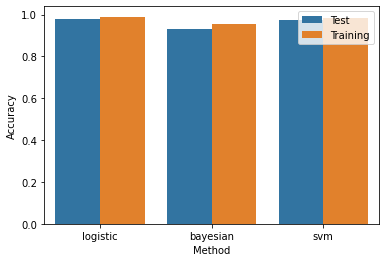

In [13]:
compare(5)

从表格中可以看出, 逻辑回归的训练用时较长, 而朴素贝叶斯分类器与支持向量机的训练用时较短.
朴素贝叶斯分类器的训练过程是一个简单的计数过程, 所以训练很高效. 逻辑回归与支持向量机的训练都用到了迭代优化的方法,
两者训练时间上的差异主要是由于具体实现的性能优化程度不同所致的.

从表格和柱状图中可以看出, 三个学习算法在训练集和测试集上都取得了不错的预测准确率,
逻辑回归和支持向量机的预测准确率相当, 而朴素贝叶斯分类器的预测准确率略低于另两者.
朴素贝叶斯分类器假设属性两两之间条件独立, 而现实数据并不完全符合这一假设,
所以朴素贝叶斯分类器的预测准确率略低于另两个学习算法.

三个学习算法的不同体现在它们从不同角度进行建模. 逻辑回归对后验概率进行建模,
提出了$logit(P(C_1 \mid \boldsymbol{x})) = \boldsymbol{w}^\mathrm{T}\boldsymbol{x} + w_0$.
朴素贝叶斯学习器对属性与标记的联合概率建模, 提出了$P(x_1, x_2, \ldots, x_d, c) = P(c)\prod_{i=1}^dP(x_i \mid c)$.
支持向量机从几何的角度建模, 试图找出一个最优的超平面来划分两类数据点.

三个学习算法的优缺点主要体现在以下几个方面.

1. 多分类: 朴素贝叶斯分类器与逻辑回归都可以直接应用于多分类任务. 支持向量机应用于多分类任务则较为困难.

2. 性能: 朴素贝叶斯分类器的训练过程是一个简单的计数过程, 用时较短.
逻辑回归与支持向量机的训练都用到了迭代优化的方法, 用时较长.

3. 假设: 逻辑回归假设每个属性都服从正态分布, 支持向量机假设在应用核方法之后两类数据点是线性可分的,
这两个假设在现实任务中被满足的可能性较高. 朴素贝叶斯分类器假设属性两两之间条件独立,
这个假设在现实任务中被满足的可能性较低.

4. 预处理: 逻辑回归与支持向量机的预处理过程需要将非数值型的属性的每个属性值映射为一个数值.
朴素贝叶斯分类器的预处理过程需要将非离散属性离散化.